In [46]:
import sys
import os

_path_added = False

def add_project_root_to_path():
    """
    Check if the project root directory is in the Python path.
    If not, add it to sys.path and change the working directory to the project root.
    """
    global _path_added

    if _path_added:
        return
    
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

    if root_dir not in sys.path:
        sys.path.append(root_dir)
        print(f"Added {root_dir} to Python path.")
    
    if os.getcwd() != root_dir:
        os.chdir(root_dir)
        print(f"Changed working directory to {root_dir}.")
    _path_added = True


add_project_root_to_path()

Added /home/developing_nacho/fhdw/web_social_analytics/dj-gpt to Python path.
Changed working directory to /home/developing_nacho/fhdw/web_social_analytics/dj-gpt.


In [47]:
os.chdir("/home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping")

In [48]:
import pandas as pd
import networkx as nx
import requests
from io import BytesIO
from PIL import Image
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, func, extract
from collections import Counter
from dorfterror_database.database_structure import Base, Post, Profile, Collaborator, Comment, Likes, Follower
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from collections import defaultdict
from datetime import datetime

# Dein ORM-Modelle hier importieren, z.B. Profile, Post, Comment, Collaborator
# from models import Profile, Post, Comment, Collaborator

root_path = Path(".").resolve()
print(root_path)

engine = create_engine(f"sqlite:///{root_path}/dorfterror_database/dorfterror.db")
Base.metadata.create_all(engine)

Session = sessionmaker(bind=engine)
session = Session()

/home/developing_nacho/fhdw/web_social_analytics/dj-gpt/insta_scraping


In [49]:
# DataFrame vorbereiten (falls noch nicht geschehen)
posts = session.query(Post).all()
df_posts = pd.DataFrame([{
    'id': p.id,
    'date_local': p.date_local,
    'content_type': p.content_type,
    'like_count': p.like_count or 0,
    'comment_count': p.comment_count or 0,
    'caption_hashtags': p.caption_hashtags or [],
    'caption_mentions': p.caption_mentions or []
} for p in posts])

# Wochentag als Name extrahieren
df_posts['weekday'] = df_posts['date_local'].dt.day_name()

# Reihenfolge der Wochentage
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Post-Anzahl pro Wochentag
weekday_counts = df_posts['weekday'].value_counts().reindex(ordered_days).fillna(0)

# DataFrame für Plotly
df_weekdays = pd.DataFrame({
    'Wochentag': weekday_counts.index,
    'Anzahl Posts': weekday_counts.values
})

fig = px.bar(
    df_weekdays,
    x='Wochentag',
    y='Anzahl Posts',
    title='Anzahl der Posts pro Wochentag',
    labels={'Anzahl Posts': 'Anzahl Posts', 'Wochentag': 'Wochentag'},
    color='Anzahl Posts',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    xaxis_tickangle=45,
    margin=dict(t=50, b=150)
)

fig.show()


In [50]:
# Sicherstellen, dass 'date_local' datetime ist
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])

# Stunde extrahieren
df_posts['hour'] = df_posts['date_local'].dt.hour

# Anzahl Posts pro Stunde zählen und sortieren
post_counts_per_hour = df_posts['hour'].value_counts().sort_index()

# Achsenlabels
labels = [f"{h:02d}:00 - {h+1:02d}:00" for h in post_counts_per_hour.index]

# DataFrame für Plotly
df_hourly = pd.DataFrame({
    'Uhrzeit': labels,
    'Anzahl Posts': post_counts_per_hour.values
})

fig = px.bar(
    df_hourly,
    x='Uhrzeit',
    y='Anzahl Posts',
    title='Verteilung der Posts nach Uhrzeit',
    labels={'Anzahl Posts': 'Anzahl der Posts', 'Uhrzeit': 'Uhrzeit'},
    color_discrete_sequence=['skyblue']
)

fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(showgrid=True),
    margin=dict(t=50, b=150)
)

fig.show()


In [51]:
# Sicherstellen, dass 'date_local' datetime ist
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])

# Wochentag extrahieren (0=Montag,...)
df_posts['weekday'] = df_posts['date_local'].dt.dayofweek

# Wochentagsnamen
weekday_labels = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']

# Likes pro Wochentag summieren (reindex für alle Tage)
likes_per_weekday = df_posts.groupby('weekday')['like_count'].sum().reindex(range(7)).fillna(0)

# DataFrame für Plotly
df_likes_weekday = pd.DataFrame({
    'Wochentag': weekday_labels,
    'Likes': likes_per_weekday.values
})

fig = px.bar(
    df_likes_weekday,
    x='Wochentag',
    y='Likes',
    title='Gesamte Likes nach Wochentag',
    labels={'Likes': 'Gesamtzahl der Likes', 'Wochentag': 'Wochentag'},
    color_discrete_sequence=['mediumseagreen']
)

fig.update_layout(yaxis=dict(showgrid=True))

fig.show()


In [52]:
content_counts = df_posts['content_type'].value_counts().reset_index()
content_counts.columns = ['Content Format', 'Anzahl']

fig = px.pie(
    content_counts,
    values='Anzahl',
    names='Content Format',
    title='Verteilung der Content-Formate',
    color_discrete_sequence=px.colors.qualitative.Pastel
)

fig.show()


In [53]:
likes_by_format = df_posts.groupby('content_type')['like_count'].sum()
likes_pct = (likes_by_format / likes_by_format.sum()) * 100

df_likes_pct = likes_pct.reset_index()
df_likes_pct.columns = ['Content Format', 'Prozentualer Anteil (%)']

fig = px.bar(
    df_likes_pct,
    x='Content Format',
    y='Prozentualer Anteil (%)',
    title='Prozentualer Anteil Likes pro Content-Format',
    labels={'Prozentualer Anteil (%)': 'Anteil (%)', 'Content Format': 'Content-Format'},
    color='Prozentualer Anteil (%)',
    color_continuous_scale='cividis'
)

fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(title='Anteil (%)'),
    xaxis=dict(title='Content-Format'),
    coloraxis_colorbar=dict(title="Anteil (%)")
)

fig.show()

In [54]:
comments_by_format = df_posts.groupby('content_type')['comment_count'].sum()
comments_pct = (comments_by_format / comments_by_format.sum()) * 100

# DataFrame für Plotly
df_pct = comments_pct.reset_index()
df_pct.columns = ['Content Format', 'Prozentualer Anteil (%)']

fig = px.bar(
    df_pct,
    x='Content Format',
    y='Prozentualer Anteil (%)',
    title='Prozentualer Anteil Kommentare pro Content-Format',
    labels={'Prozentualer Anteil (%)': 'Anteil (%)', 'Content Format': 'Content-Format'},
    color='Prozentualer Anteil (%)',
    color_continuous_scale='viridis'
)

fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(title='Anteil (%)'),
    xaxis=dict(title='Content-Format'),
    coloraxis_colorbar=dict(title="Anteil (%)")
)

fig.show()

In [55]:
all_hashtags = [hashtag.lower() for hashtags in df_posts['caption_hashtags'] for hashtag in (hashtags if hashtags else [])]
top_hashtags = Counter(all_hashtags).most_common(20)
hashtags, counts = zip(*top_hashtags)

# DataFrame für Plotly vorbereiten
df_hashtags = pd.DataFrame({
    'Hashtag': hashtags,
    'Anzahl': counts
})

# Plotly Balkendiagramm horizontal
fig = px.bar(
    df_hashtags,
    x='Anzahl',
    y='Hashtag',
    orientation='h',
    color='Anzahl',
    color_continuous_scale='viridis',
    title='Top 20 häufigste Hashtags',
    labels={'Anzahl': 'Anzahl', 'Hashtag': 'Hashtag'}
)

# Sortierung y-Achse (Top von oben)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

fig.show()


In [56]:
dorfterror_profile = session.query(Profile).filter(Profile.username == 'dorfterror').first()

# Alle Kollaborationen von Dorfterror laden
dorfterror_post_ids = [
    p.id for p in session.query(Post).filter(Post.user_posted == dorfterror_profile.username)
]

collabs = session.query(Collaborator).filter(Collaborator.post_id.in_(dorfterror_post_ids)).all()

# Zähle, wie oft jeder Kollaborator mit Dorfterror zusammenarbeitet
collab_counts = Counter([c.profile_id for c in collabs])

# Profilinfos laden
collab_profiles = session.query(Profile).filter(Profile.id.in_(list(collab_counts.keys()))).all()
id_to_profile = {p.id: p for p in collab_profiles}

# Netzwerk erstellen
G = nx.Graph()
G.add_node(dorfterror_profile.username, size=1000, image_url=dorfterror_profile.profile_image_link)

# Knoten für Kollaboratoren hinzufügen
for collab_id, count in collab_counts.items():
    profile = id_to_profile.get(collab_id)
    if profile:
        G.add_node(profile.username, size=300 + count * 100, image_url=profile.profile_image_link)
        G.add_edge(dorfterror_profile.username, profile.username)


# Layout mit mehr Platz
#pos = nx.spring_layout(G, k=1.2, seed=42)

import numpy as np

def get_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def resolve_overlaps(pos, sizes, min_dist_factor=1.2, max_iter=200):
    """
    Verschiebt Knoten, falls sie sich basierend auf ihrer Bildgröße überlappen.
    """
    for _ in range(max_iter):
        moved = False
        for n1 in pos:
            for n2 in pos:
                if n1 == n2:
                    continue
                p1, p2 = np.array(pos[n1]), np.array(pos[n2])
                dist = get_distance(p1, p2)
                min_dist = (sizes[n1] + sizes[n2]) * min_dist_factor / 20  # Skalierung für Abstand

                if dist < min_dist:
                    # Richtung berechnen, um Knoten zu verschieben
                    direction = (p1 - p2) / (dist + 1e-5)
                    shift = (min_dist - dist) / 2
                    pos[n1] = tuple(p1 + direction * shift)
                    pos[n2] = tuple(p2 - direction * shift)
                    moved = True
        if not moved:
            break
    return pos


# 1. Knoten und Positionen vorbereiten
center_node = dorfterror_profile.username
other_nodes = [n for n in G.nodes if n != center_node]

num_nodes = len(other_nodes)
angle_step = 2 * np.pi / max(num_nodes, 1)

max_size = max(G.nodes[n]["size"] for n in other_nodes) if other_nodes else 1

pos_plotly = {center_node: (0, 0)}
for i, node in enumerate(sorted(other_nodes)):
    angle = i * angle_step
    size = G.nodes[node]["size"]
    radius = 2 + 4 * (size / max_size)
    x = np.cos(angle) * radius
    y = np.sin(angle) * radius
    pos_plotly[node] = (x, y)

# 2. Kanten für Linien vorbereiten
edge_x = []
edge_y = []
for edge in G.edges:
    x0, y0 = pos_plotly[edge[0]]
    x1, y1 = pos_plotly[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# 3. Knoten vorbereiten (Position, Größe, Hovertext)
node_x = []
node_y = []
node_size = []
node_text = []

for node in G.nodes:
    x, y = pos_plotly[node]
    node_x.append(x)
    node_y.append(y)
    node_size.append(G.nodes[node]["size"] / 15 + 20)  # Knotengröße anpassen
    if node == center_node:
        hovertext = f"{node} (Zentrum)"
    else:
        # Kollabanzahl abrufen
        profile_id = None
        for pid, prof in id_to_profile.items():
            if prof.username == node:
                profile_id = pid
                break
        count = collab_counts.get(profile_id, 0) if profile_id else 0
        hovertext = f"{node}<br>Kollaborationen: {count}"
    node_text.append(hovertext)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[center_node if node == center_node else "" for node in G.nodes],  # Nur Zentrum beschriften
    textposition="bottom center",
    marker=dict(
        showscale=False,
        color='lightblue',
        size=node_size,
        line_width=2,
        line_color='black',
    ),
    textfont=dict(size=12),
    hovertext=node_text
)

# 4. Profilbilder als Layout Images (rund zugeschnitten musst du ggf. vorbearbeiten)
images = []
for node in G.nodes:
    x, y = pos_plotly[node]
    size_px = node_size[list(G.nodes).index(node)] * 3  # Pixelgröße der Bilder (Anpassbar)

    img_url = G.nodes[node].get('image_url') or "https://via.placeholder.com/150"

    images.append(dict(
        source=img_url,
        xref="x", yref="y",
        x=x - 0.1, y=y + 0.1,
        sizex=0.2, sizey=0.2,
        xanchor="center",
        yanchor="middle",
        layer="above",
        sizing="contain",
        opacity=1
    ))

# 5. Plotly Figur erstellen
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Netzwerk: Kollaboratoren von Dorfterror",
                    title_x=0.5,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-6,6]),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, range=[-6,6]),
                    images=images
                ))

fig.show()

## Alte Version mit Matplotlib

Fehler bei dorfterror: 403 Client Error: Forbidden for url: https://scontent-cdg4-2.cdninstagram.com/v/t51.2885-19/468566340_1080483403382431_3800128179714413222_n.jpg?stp=dst-jpg_s320x320_tt6&_nc_ht=scontent-cdg4-2.cdninstagram.com&_nc_cat=107&_nc_oc=Q6cZ2QFMtMF9zvB5aECEDFIfajeSOdMxUHq0yUwvOmNfYOK4wKUQZhe8WiFCR8wg6eJHHgI&_nc_ohc=cl_x3tc0wvgQ7kNvwH6iRrq&_nc_gid=ptLv-dxArep7DJ6QsyiUdA&edm=AOQ1c0wBAAAA&ccb=7-5&oh=00_AfRtmoUvuBlid_D_dP8QtIY88V6xwYBt1Ckz2tPl6nJk1g&oe=68746D70&_nc_sid=8b3546
Fehler bei muselkanner: 403 Client Error: Forbidden for url: https://scontent-gig4-2.cdninstagram.com/v/t51.2885-19/52699500_1006762016200981_3772279542832431104_n.jpg?stp=dst-jpg_s320x320_tt6&_nc_ht=scontent-gig4-2.cdninstagram.com&_nc_cat=101&_nc_oc=Q6cZ2QFtp2oBggFeBQX_FSri0TnODLJywWuzkqwpjKNY8nn_0_Waco0nZC-w3BusWQ6nSMM&_nc_ohc=OXjDD6xFYAAQ7kNvwEqlU5l&_nc_gid=ebotPhv00L9iLEPWaUOnMQ&edm=AOQ1c0wBAAAA&ccb=7-5&oh=00_AfRY03jgxwiVFX8FLe6rh7bPH924N_k3A98n5tAofsmWdQ&oe=687831C8&_nc_sid=8b3546
Fehler bei alter

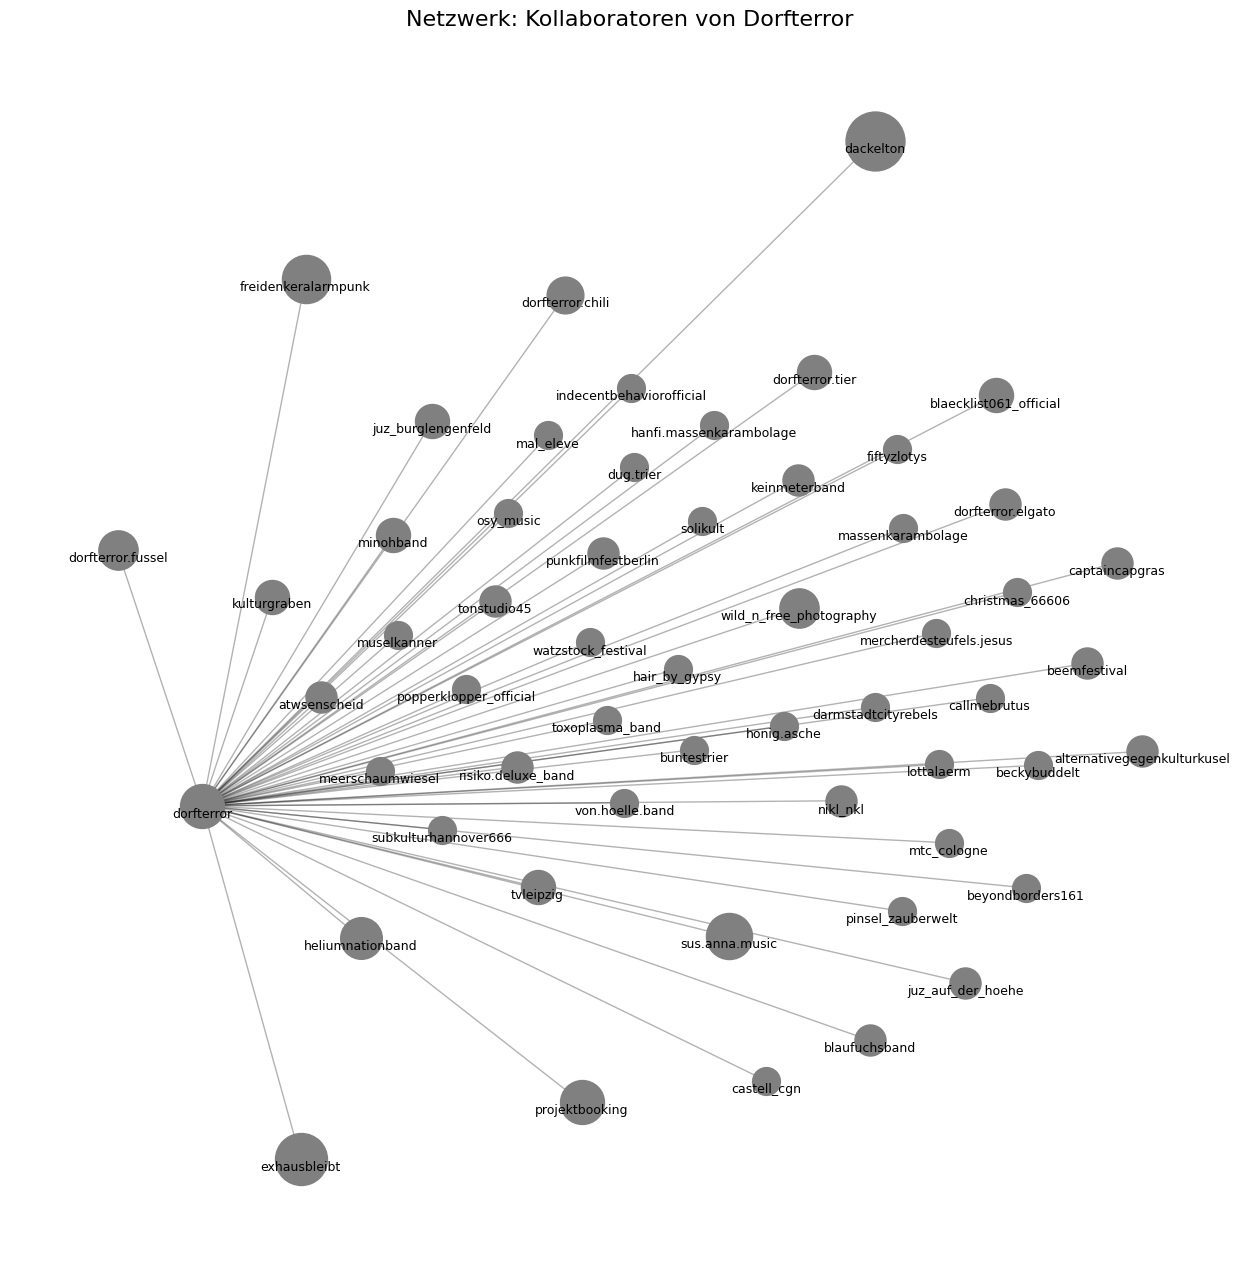

In [57]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import numpy as np

dorfterror_profile = session.query(Profile).filter(Profile.username == 'dorfterror').first()

# Alle Kollaborationen von Dorfterror laden
dorfterror_post_ids = [
    p.id for p in session.query(Post).filter(Post.user_posted == dorfterror_profile.username)
]

collabs = session.query(Collaborator).filter(Collaborator.post_id.in_(dorfterror_post_ids)).all()

# Zähle, wie oft jeder Kollaborator mit Dorfterror zusammenarbeitet
collab_counts = Counter([c.profile_id for c in collabs])

# Profilinfos laden
collab_profiles = session.query(Profile).filter(Profile.id.in_(list(collab_counts.keys()))).all()
id_to_profile = {p.id: p for p in collab_profiles}

# Netzwerk erstellen
G = nx.Graph()
G.add_node(dorfterror_profile.username, size=1000, image_url=dorfterror_profile.profile_image_link)

# Knoten für Kollaboratoren hinzufügen
for collab_id, count in collab_counts.items():
    profile = id_to_profile.get(collab_id)
    if profile:
        G.add_node(profile.username, size=300 + count * 100, image_url=profile.profile_image_link)
        G.add_edge(dorfterror_profile.username, profile.username)


# Layout mit mehr Platz
#pos = nx.spring_layout(G, k=1.2, seed=42)

import numpy as np

def get_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def resolve_overlaps(pos, sizes, min_dist_factor=1.2, max_iter=200):
    """
    Verschiebt Knoten, falls sie sich basierend auf ihrer Bildgröße überlappen.
    """
    for _ in range(max_iter):
        moved = False
        for n1 in pos:
            for n2 in pos:
                if n1 == n2:
                    continue
                p1, p2 = np.array(pos[n1]), np.array(pos[n2])
                dist = get_distance(p1, p2)
                min_dist = (sizes[n1] + sizes[n2]) * min_dist_factor / 20  # Skalierung für Abstand

                if dist < min_dist:
                    # Richtung berechnen, um Knoten zu verschieben
                    direction = (p1 - p2) / (dist + 1e-5)
                    shift = (min_dist - dist) / 2
                    pos[n1] = tuple(p1 + direction * shift)
                    pos[n2] = tuple(p2 - direction * shift)
                    moved = True
        if not moved:
            break
    return pos


# Schritt 1: Zentrum setzen
center_node = dorfterror_profile.username
pos = {center_node: (0, 0)}

# Schritt 2: Kollaboratoren radial verteilen
other_nodes = [n for n in G.nodes if n != center_node]
num_nodes = len(other_nodes)
angle_step = 2 * np.pi / num_nodes

# Maximale Knotengröße für Radiusberechnung
max_size = max(G.nodes[n]["size"] for n in other_nodes)
sizes = {n: G.nodes[n]["size"] / 10 for n in G.nodes}  # Bildgröße zur Abstandskalkulation

# Erste Platzierung
for i, node in enumerate(sorted(other_nodes)):
    angle = i * angle_step
    size = G.nodes[node]["size"]
    radius = 2 + 4 * (size / max_size)
    x = np.cos(angle) * radius
    y = np.sin(angle) * radius
    pos[node] = (x, y)

# Schritt 3: Überlappungen korrigieren
pos = resolve_overlaps(pos, sizes)



plt.figure(figsize=(16, 16))
ax = plt.gca()
nx.draw_networkx_edges(G, pos, alpha=0.3)

for node in G.nodes:
    x, y = pos[node]
    node_size = G.nodes[node]['size']
    img_url = G.nodes[node].get('image_url') or "https://via.placeholder.com/150"

    try:
        headers = {
            "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(img_url, headers=headers, timeout=5)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content)).convert("RGBA")

        size = int(node_size / 10)
        img = img.resize((size, size), Image.LANCZOS)

        # Runde Maske
        mask = Image.new('L', (size, size), 0)
        draw_mask = ImageDraw.Draw(mask)
        draw_mask.ellipse((0, 0, size, size), fill=255)

        # Dünner schwarzer Rand
        border_size = 2  # SCHMALER gemacht
        bordered_img = Image.new("RGBA", (size + 2 * border_size, size + 2 * border_size), (0, 0, 0, 0))
        border_draw = ImageDraw.Draw(bordered_img)
        border_draw.ellipse(
            (0, 0, size + 2 * border_size, size + 2 * border_size),
            fill=(0, 0, 0, 255)  # schwarzer Rand
        )

        # Bild mit runder Maske einfügen
        img.putalpha(mask)
        bordered_img.paste(img, (border_size, border_size), img)

        # Anzeige als runder Knoten mit dünnem Rand
        img_box = OffsetImage(bordered_img, zoom=1)
        ab = AnnotationBbox(img_box, (x, y), frameon=False)
        ax.add_artist(ab)

        # Dynamischer Abstand basierend auf tatsächlicher Bildhöhe in Datenkoordinaten
        fig = plt.gcf()
        ax = plt.gca()
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        ax_width, ax_height = bbox.width, bbox.height

        # Größe des Bildes in Datenkoordinaten (grob geschätzt)
        scale = ax.transData.inverted().transform([(0, 0), (0, size)])
        dy = abs(scale[1][1] - scale[0][1])

        plt.text(x, y - dy / 2 - 1, node, ha='center', va='top', fontsize=9)


    except Exception as e:
        print(f"Fehler bei {node}: {e}")
        # Fallback: grauer Kreis und Text
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=node_size, node_color='gray', ax=ax)
        plt.text(x, y - 0.1, node, ha='center', va='top', fontsize=9)


plt.title('Netzwerk: Kollaboratoren von Dorfterror', fontsize=16)
plt.axis('off')
plt.show()

In [58]:
mentions = [mention.lower() for mentions_list in df_posts['caption_mentions'] for mention in (mentions_list if mentions_list else [])]
from collections import Counter
top_mentions = Counter(mentions).most_common(20)
mention_names, mention_counts = zip(*top_mentions)

df_mentions = pd.DataFrame({
    'Profil': mention_names,
    'Anzahl': mention_counts
})

fig = px.bar(
    df_mentions,
    x='Anzahl',
    y='Profil',
    orientation='h',
    color='Anzahl',
    color_continuous_scale='RdBu',
    title='Top 20 häufigste markierte Profile',
    labels={'Anzahl': 'Anzahl', 'Profil': 'Profil'}
)

fig.update_layout(yaxis={'categoryorder':'total ascending'}, 
                  margin=dict(l=120), 
                  height=600)
fig.show()

In [59]:
comments = session.query(Comment).filter(Comment.text != None).all()
df_comments = pd.DataFrame([{
    'text_length': len(c.text),
    'post_id': c.post_id
} for c in comments])

import plotly.graph_objects as go
import numpy as np


hist_data = df_comments['text_length']
avg_comment_length = hist_data.mean()

fig = go.Figure()

fig.add_trace(go.Histogram(
    x=hist_data,
    nbinsx=30,
    name='Kommentar-Längen',
    marker=dict(
        color='limegreen',     # grelle Farbe
        line=dict(color='black', width=1)  # schwarze Umrandung
    ),
    opacity=0.75
))

fig.add_trace(go.Scatter(
    x=[avg_comment_length, avg_comment_length],
    y=[0, hist_data.value_counts().max() * 1.1],
    mode='lines',
    line=dict(color='red', dash='dash'),
    name=f'Durchschnitt: {avg_comment_length:.1f} Zeichen'
))

fig.update_layout(
    title=f'Durchschnittliche Kommentarlänge: {avg_comment_length:.1f} Zeichen',
    xaxis_title='Länge Kommentar (Zeichen)',
    yaxis_title='Anzahl Kommentare',
    bargap=0.1,
    width=700,
    height=450
)

fig.show()


In [60]:
avg_comments_format = df_posts.groupby('content_type')['comment_count'].mean().reset_index()

fig = px.bar(
    avg_comments_format,
    x='content_type',
    y='comment_count',
    color='comment_count',
    color_continuous_scale='magma',
    labels={'content_type': 'Content-Format', 'comment_count': 'Durchschnitt Kommentare'},
    title='Durchschnittliche Kommentaranzahl pro Content-Format'
)

fig.update_layout(
    xaxis_tickangle=45,
    height=500,
    width=700
)

fig.show()



### Follower diagramms

#### Where are the likes coming from?

In [61]:
likes = session.query(Likes).all()
followers = session.query(Follower).all()
follower_ids = set(f.profile_id for f in followers)

df_likes = pd.DataFrame([{
    'profile_id': l.profile_id,
    'post_id': l.post_id,
    'is_follower': l.profile_id in follower_ids
} for l in likes])

avg_follower_ratio = df_likes['is_follower'].mean()
avg_non_follower_ratio = 1 - avg_follower_ratio

# Values from your code
labels = ['Followers', 'Non-Followers']
values = [avg_follower_ratio, avg_non_follower_ratio]

fig = go.Figure(data=[
    go.Bar(
        x=labels,
        y=values,
        marker_color=['steelblue', 'indianred'],
        text=[f"{v:.2%}" for v in values],  # show % labels
        textposition='auto'
    )
])

fig.update_layout(
    title='Average Like Ratio by Follower Type',
    xaxis_title='User Type',
    yaxis_title='Share of Likes',
    yaxis_tickformat='.0%',
    template='plotly_white',
    height=500,
    width=600
)

fig.show()


#### How many followers vs non-followers liked the top posts?

In [62]:
# Step 1: Query data
likes = session.query(Likes).all()
followers = session.query(Follower).all()
follower_ids = set(f.profile_id for f in followers)

posts = session.query(Post).all()
post_map = {p.id: p for p in posts}

# Step 2: Count likes
post_like_count = defaultdict(lambda: {'follower': 0, 'non_follower': 0})
for like in likes:
    if like.post_id in post_map:
        is_follower = like.profile_id in follower_ids
        if is_follower:
            post_like_count[like.post_id]['follower'] += 1
        else:
            post_like_count[like.post_id]['non_follower'] += 1

# Step 3: Build DataFrame
def caption_snippet(caption, word_count=4):
    if not caption:
        return "(No caption)"
    return " ".join(caption.split()[:word_count]) + ("..." if len(caption.split()) > word_count else "")

df_top_likes = pd.DataFrame([
    {
        'caption_snippet': caption_snippet(post_map[pid].caption),
        'follower': counts['follower'],
        'non_follower': counts['non_follower'],
        'total': counts['follower'] + counts['non_follower']
    }
    for pid, counts in post_like_count.items()
])

df_top_likes = df_top_likes.sort_values('total', ascending=False).head(10)

# Step 4: Plotly stacked bar
fig = go.Figure(data=[
    go.Bar(
        name='Follower Likes',
        x=df_top_likes['caption_snippet'],
        y=df_top_likes['follower'],
        marker_color='steelblue'
    ),
    go.Bar(
        name='Non-Follower Likes',
        x=df_top_likes['caption_snippet'],
        y=df_top_likes['non_follower'],
        marker_color='indianred'
    )
])

fig.update_layout(
    barmode='stack',
    title='Top 10 Posts by Likes (Followers vs Non-Followers)',
    xaxis_title='Post Caption (Shortened)',
    yaxis_title='Like Count',
    xaxis_tickangle=45,
    template='plotly_white',
    legend=dict(title='Like Source'),
    height=600,
    width=1000,
    bargap=0.2  # smaller gap makes bars thicker
)

fig.show()



#### Likes on a time series

In [63]:
# Convert 'date_local' to datetime and extract month
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])
df_posts['month'] = df_posts['date_local'].dt.to_period('M')

# Group and prepare data
df_monthly = df_posts.groupby('month')['like_count'].sum().reset_index()
df_monthly['month'] = df_monthly['month'].astype(str)

# Create interactive plot
fig = px.line(
    df_monthly,
    x='month',
    y='like_count',
    title='Cumulated Likes Per Month',
    markers=True,
    labels={'month': 'Month', 'like_count': 'Total Likes'}
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Total Likes',
    xaxis_tickangle=-45,
    template='plotly_white'
)

fig.show()


In [64]:
# Ensure 'date_local' is datetime and sort
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])
df_posts_sorted = df_posts.sort_values(by='date_local')

# Interactive timeline plot
fig = px.line(
    df_posts_sorted,
    x='date_local',
    y='like_count',
    title='Likes Timeline for Each Post',
    markers=True,
    labels={'date_local': 'Post Date', 'like_count': 'Likes'}
)

# Customize layout
fig.update_layout(
    xaxis_title='Post Date',
    yaxis_title='Like Count',
    xaxis_tickangle=-45,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

In [65]:
# Ensure 'date_local' is datetime
df_posts['date_local'] = pd.to_datetime(df_posts['date_local'])

# Filter posts from 2022 onwards
start_date = datetime(2022, 1, 1)
df_recent_posts = df_posts[df_posts['date_local'] >= start_date]

# Sort by date
df_recent_posts_sorted = df_recent_posts.sort_values(by='date_local')

# Create interactive plot
fig = px.line(
    df_recent_posts_sorted,
    x='date_local',
    y='like_count',
    title='Likes Timeline for Posts Since 2022',
    markers=True,
    labels={'date_local': 'Post Date', 'like_count': 'Likes'}
)

# Customize layout
fig.update_layout(
    xaxis_title='Post Date',
    yaxis_title='Like Count',
    xaxis_tickangle=-45,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


#### What stats has the average follower?

In [66]:
profiles = session.query(Profile).all()
profile_dict = {p.id: p for p in profiles}

df_profiles = pd.DataFrame([{
    'id': p.id,
    'follower_count': p.follower_count or 0,
    'followees_count': p.followees_count or 0,
    'post_count': p.post_count or 0
} for p in profiles if p.id in [f.profile_id for f in followers]])

df_followers_stats = pd.DataFrame([{
    'profile_id': f.profile_id,
    'likes_count': f.likes_count or 0
} for f in followers])

df_merged = df_profiles.merge(df_followers_stats, left_on='id', right_on='profile_id', how='inner')

# Prepare averages dictionary
averages = {
    'Followers': df_merged['follower_count'].mean(),
    'Followees': df_merged['followees_count'].mean(),
    'Posts': df_merged['post_count'].mean(),
    'Likes': df_merged['likes_count'].mean()
}

# Convert to DataFrame for Plotly
df_avg = pd.DataFrame(list(averages.items()), columns=['Metric', 'Average'])

# Create interactive bar chart
fig = px.bar(
    df_avg,
    x='Metric',
    y='Average',
    text='Average',
    title="Average Metrics per Follower Profile",
    labels={'Average': 'Average Value'},
    color='Metric',
    color_discrete_sequence=px.colors.qualitative.Set3
)

fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

fig.update_layout(
    yaxis_title="Average Value",
    xaxis_title="Profile Metric",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    template='plotly_white'
)

fig.show()


#### Who are the top profile who Like the most?

In [67]:
# Fetch all likes
likes = session.query(Likes).all()

# Count likes per profile
like_counts = Counter([like.profile_id for like in likes if like.profile_id])

# Convert to DataFrame
df_top_likers = pd.DataFrame(like_counts.items(), columns=['profile_id', 'like_count'])

# Map usernames
profiles = session.query(Profile).all()
profile_map = {p.id: p.username for p in profiles}
df_top_likers['username'] = df_top_likers['profile_id'].map(profile_map)

# Sort and select top 10
df_top_likers = df_top_likers.sort_values('like_count', ascending=False).head(10)

# Plot with Plotly
fig = px.bar(
    df_top_likers,
    x='username',
    y='like_count',
    text='like_count',
    title='Top 10 Profiles That Liked the Most Posts',
    labels={'like_count': 'Number of Likes Given', 'username': 'Username'},
    color='like_count',
    color_continuous_scale='Blues'
)

# Add spacing and improve visibility
max_likes = df_top_likers['like_count'].max()
fig.update_traces(textposition='outside')

fig.update_layout(
    yaxis=dict(range=[0, max_likes * 1.15]),  # Add 15% headroom
    xaxis_tickangle=45,
    template='plotly_white',
    margin=dict(t=80),  # More top margin
    yaxis_title='Likes Given',
    xaxis_title='Username'
)

fig.show()